### Imports

In [2]:
import pandas as pd
import plotnine
from plotnine import ggplot, aes, geom_bar, labs, theme, element_text, scale_x_discrete, scale_x_continuous, geom_text, geom_line, geom_smooth, stat_smooth
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import numpy as np
import gensim
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import time
import datetime
import collections
from dash import Dash, dcc, html
import plotly.express as px
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash import Dash, dcc, html
from dash import Dash, dcc, html, Input, Output
from wordcloud import WordCloud
import re
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import warnings
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
import os
from pprint import pprint

[nltk_data] Downloading package stopwords to C:\Users\Goutham
[nltk_data]     Yegappan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
warnings.filterwarnings("ignore")


C:\Users\Goutham Yegappan\Python\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Get Data

In [4]:
data = pd.read_json('BrowserHistory.json')
data = pd.DataFrame.from_dict([r for r in data['Browser History']])
data['date'] = [datetime.datetime.fromtimestamp(int(str(c)[:10])).strftime('%Y-%m-%d %H:%M:%S') for c in data['time_usec']]

# Last 3 Months
data = data[:30000]

# Round Hour And Get Time
def get_hour(times):
    times = times.split()[1].split(':')[:-1]
    min = times[1]
    hour = times[0]

    if int(min) > 30:

        hour = (int(hour) + 1) % 24
    else:
        hour = int(hour)
    
    return str(hour)

# I CHANGED HOUR TO INT
data['date_hour'] = data['date'].map(get_hour)

data['date_day'] = [day.split()[0].split('-')[2] for day in data['date']]
data.head()

,favicon_url,page_transition,title,url,client_id,time_usec,date,date_hour,date_day
0,https://www.google.com/favicon.ico,LINK,Google Takeout,https://takeout.google.com/settings/takeout?pli=1,ShiSundftrDEN+C5A0AmaA==,1670093218129086,2022-12-03 10:46:58,11,03
1,https://www.google.com/favicon.ico,LINK,Google Takeout,https://takeout.google.com/settings/takeout?pli=1,ShiSundftrDEN+C5A0AmaA==,1670093210175359,2022-12-03 10:46:50,11,03
2,https://www.google.com/favicon.ico,LINK,Google Takeout,https://takeout.google.com/settings/takeout?pli=1,ShiSundftrDEN+C5A0AmaA==,1670093190044387,2022-12-03 10:46:30,11,03
3,NaN,LINK,Google Takeout,https://takeout.google.com/settings/takeout?pli=1,ShiSundftrDEN+C5A0AmaA==,1670093188521893,2022-12-03 10:46:28,11,03
4,NaN,GENERATED,google takeout - Google Search,https://www.google.com/search?q=google+takeout...,ShiSundftrDEN+C5A0AmaA==,1670093187824940,2022-12-03 10:46:27,11,03


In [5]:
data['weekday'] = [datetime.datetime.fromtimestamp(int(str(c)[:10])).weekday() for c in data['time_usec']]
data['date_month'] = [day.split()[0].split('-')[1] for day in data['date']]


In [6]:
# Count the total number of days and how many times it is possible for something to, this report should run only every sunday

def days_passed():
    end = datetime.datetime.fromtimestamp(int(str(data['time_usec'].iloc[0])[:10]))
    begin = datetime.datetime.fromtimestamp(int(str(data['time_usec'].iloc[-1])[:10]))
    return (end - begin).days

day_pass = days_passed()

# Act like its even 7 weeks
day_pass += 1
week_pass = day_pass/7

In [7]:
num_to_day = {0: 'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6: 'Saturday'}

In [8]:
def get_week_data(df):
    week_of_day_data = df['weekday'].value_counts()/week_pass
    week_of_day_data.sort_index(inplace = True)
    week_of_day_data.rename(index = num_to_day, inplace = True)
    return week_of_day_data

vals2 = get_week_data(data.iloc[:10000])

### Get Counts of Any Search

In [9]:
def wanted_search(title):
    youtube = [tit for tit in data['title'] if title in tit]

    # split values
    all_youtube = ' '.join([' '.join(t) for t in [v.split()[:-2] for v in youtube]]).lower()
    youtube_counts = collections.Counter(all_youtube.split())
    counts = pd.DataFrame.from_dict(youtube_counts, orient='index')
    counts = counts.loc[[idx for idx in counts.index if len(idx) > 2]]

    not_words = ['the', 'and', 'for', '(1)']
    counts = counts.loc[[idx for idx in counts.index if idx not in not_words]]

    return counts
vals = wanted_search('- YouTube')
# wanted_search('TikTok')
vals = vals.sort_values(by = 0)[-20:]
# MAYBE DO SOMETHING WITH PAGE TRANSITION

### Preprocessing For Clustering

In [10]:
vals = [v.lower() for v in data['title']]
vals = [re.sub(r'[: | \ | / | -]',' ',v) for v in vals]

vals = [list(set(v.split())) for v in vals]
data_words = vals

### Wordcloud

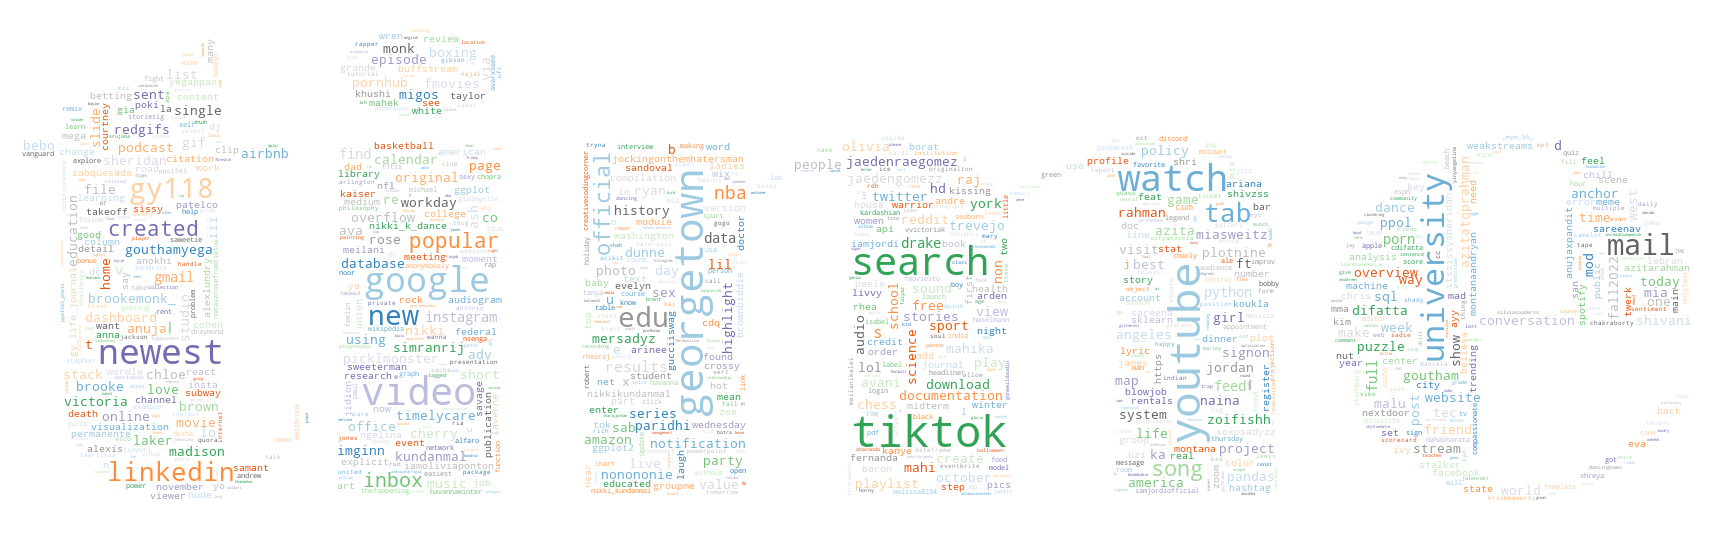

In [69]:
'''
# Remove Duplicates
all_words = ' '.join([' '.join(t) for t in [v for v in vals]])

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=0, colormap='tab20c', width = 1300, height = 400, mask = mask, collocations=False)
wordcloud.generate_from_text(all_words)
wordcloud.to_image()
wordcloud.to_file('assets/wc_image4.png')
'''

### LDA Model

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [13]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
doc_lda = lda_model[corpus]

### Give Data Which Cluster It's In

In [14]:
# Give Groups To Each Row 
ldamodel = lda_model
groups = []

# Get main topic in each document
for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            groups.append(topic_num)
data['groups'] = groups

In [15]:
for i in range(10):
    print([l[0] for l in ldamodel.show_topic(i)][:8])

['on', 'by', 'tiktok', 'songs', 'created', 'popular', 'search', 'google']
['tiktok', 'videos', 'watch', 'newest', 'search', 'youtube', 'google', 'linkedin']
['youtube', 'tiktok', 'watch', 'videos', 'on', 'newest', 'georgetown', 'university']
['tiktok', 'youtube', 'videos', 'watch', 'newest', 'university', 'georgetown', 'mail']
['tiktok', 'videos', 'watch', 'newest', 'official', 'youtube', 'on', 'search']
['linkedin', 'tiktok', 'on', 'songs', 'by', 'created', 'popular', 'youtube']
['new', 'tab', 'on', 'tiktok', 'the', 'youtube', 'university', 'georgetown']
['university', 'georgetown', 'mail', 'gy118@georgetown.edu', 'tiktok', 'videos', 'watch', 'newest']
['google', 'search', 'youtube', 'tiktok', 'watch', 'videos', 'newest', 'georgetown']
['new', 'tab', 'search', 'google', 'youtube', 'on', 'for', 'the']


### Find Number of Groups

In [16]:
def find_groups():
    score = []
    for num_topics in range(20, 40, 5):
    # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_lda = coherence_model_lda.get_coherence()
        print(num_topics, coherence_lda)
        score.append(coherence_lda)
    return score


### Model 

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/results/ldavis_prepared_'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, 'assets/lda.html')


### Application

In [67]:
vals = wanted_search('- YouTube')
# wanted_search('TikTok')
vals = vals.sort_values(by = 0)[-15:]
vals = vals.iloc[::-1]

fig_youtube = px.bar(x = vals.index, y = vals[0], title='Most Watched Youtube Videos', width=700, height = 500, 
                   labels= {"y": 'Total Views',
                            'x': 'Tag Name'}).update_layout(yaxis_title = 'Total Views')

fig_youtube.update_xaxes(tickfont_size=11)



In [64]:
tiktok_data = data[[True if 'TikTok' in t else False for t in data['title']]]
all_matches = [re.findall(r'\((.*?)\)', s) for s in tiktok_data['title']]
people = [m[0] for m in all_matches  if len(m) > 0]
vals2 = pd.Series(people).value_counts()[:15]

fig_tiktok = px.bar(x = vals2.index, y = vals2.values, title='Most Watched TikTok Creators', width=700, height = 500, 
                   labels= {"y": 'Total Views',
                            'x': 'Username'}).update_layout(yaxis_title = 'Total Views')

fig_tiktok.update_xaxes(tickfont_size=8)


In [74]:
# Load Data
df = px.data.tips()

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Time Waster Analysis"),
    html.P('Use the tool below to identify the types of internet usage that you consider to be wasteful. Once you hover over a group, the terms that \
            make that group will appear on the right. Groups that are closer together are more similar. Each axis represents a certain type of internet usage.'),
    html.Iframe(src= 'assets/lda.html', style={"height": "870px", "width": "100%"}),
    

    html.H1('Select The Groups That You Consider A Waste of Time'),
    html.P('Input all groups you find to be wasteful in the dropdown below.'),
    
    html.Label([
                dcc.Dropdown(options = list(range(1,11)),
                id="time_waster_id",
                value = [19],
                multi=True
    )]),

        
    html.Div(children = [
        dcc.Graph(id = 'graph', style={'display': 'inline-block'}),
        dcc.Graph(id = 'week', style={'display': 'inline-block'})
    ]),
    

    html.Img(src='assets/wc_image4.png', style = {'width':'95%', "border":"2px black solid"}),     
    
    html.H1('Breakdown of Most Consumed'),
    html.P('These are the 10 most watched Youtube and Tiktok creators and tags'),

    html.Div(children = [
        dcc.Graph(id = 'youtube', figure = fig_youtube, style={'display': 'inline-block'}),
        dcc.Graph(id = 'tiktok', figure = fig_tiktok, style={'display': 'inline-block'}),
    ]),
    
    html.H1('What You Can Do Today?'),
    html.P('By using this tool you can identify times in which your wasteful usage increases and implement strategies to fill that time with some \
    other activity. In addition by knowing the searches that you waste your time with most, you can increase your awareness every time you find yourself \
    searching for that.'),
    html.P('Here are some helpful websites for further information.'),
    html.P('1. https://www.marksdailyapple.com/13-ways-to-spend-less-time-online-and-reclaim-your-real-life'),
    html.P('2. https://www.breobox.com/blogs/news/ways-spend-less-time-online'),
    html.P('3. https://bookriot.com/how-to-read-more-and-internet-less-when-you-have-no-self-control')

])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("time_waster_id", "value")]
)

def update_figure(waste_idx):
    waste_idx = [w - 1 for w in waste_idx]
    data['date_hour'] = data['date_hour'].astype(int)
    dta_by_hour_total = pd.DataFrame(round(data.groupby('date_hour').count()['url']/day_pass, 1))

    df_by_waste = data[data['groups'].isin(waste_idx)]
    dta_by_hour_waste = pd.DataFrame(round(df_by_waste.groupby('date_hour').count()['url']/day_pass, 1))

    fig = px.bar(dta_by_hour_total, x = dta_by_hour_total.index, y = 'url',
                       title="Average Internet Usage Throughout The Day <br><sup> Usage Peaks Around Noon</sup>",
                       labels= {"date_hour": 'Time of Day',
                                'url': 'Average Websites Visited'}).update_layout(yaxis_title = 'Average Websites Visited')

    fig.add_trace(go.Bar(x = dta_by_hour_waste.index, y = dta_by_hour_waste['url']))
    fig.update_layout(
        barmode="overlay",
        bargap=0.1,
        xaxis = dict(tickmode = 'array',
                     tickvals = [0, 5, 10, 15, 20],
                     ticktext = ['0:00', '5:00', '10:00', '15:00', '20:00']
                    )
    )

    fig.update_xaxes(tickangle = 45)

    fig.for_each_trace(lambda t: t.update(name = 'Time Wasted',
                                         )
                      )
    
    return fig

@app.callback(
    Output('week', 'figure'),
    [Input("time_waster_id", "value")]
)

def update_week_figure(waste_idx):
    waste_idx = [w - 1 for w in waste_idx]
    data['date_hour'] = data['date_hour'].astype(int)
    df_by_waste = data[data['groups'].isin(waste_idx)]
    
    week_of_day_data = get_week_data(data)
    waste_data = get_week_data(df_by_waste)
    
    week_graph = px.line(week_of_day_data, x = week_of_day_data.index, y = week_of_day_data.values,
                       title="Internet Usage By Day of the Week <br><sup> Usage Peaks on Tuesday</sup>",
                       labels= {"index": 'Day',
                                'y': 'Average Websites Visited'}).update_layout(yaxis_title = 'Average Websites Visited')

    week_graph.add_scatter(x = waste_data.index, y = waste_data.values)
    week_graph.for_each_trace(lambda t: t.update(name = 'Time Wasted',
                                     )
                  )
    return week_graph
    
# Run app and display result inline in the notebook
app.run_server(port=9100)

Dash app running on http://127.0.0.1:9100/
